https://disassemble-channel.com/lstm-multivariate-time-series/

In [156]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable

In [157]:
url_1=r'./data_pytorch1.csv'
df = pd.read_csv(url_1, parse_dates=True, index_col=0)
df

,cloud,wind,ave_tmp,max_tmp,min_tmp,rain
2018-05-17,9.0,3.7,24.0,28.4,21.4,0.0
2018-05-18,7.8,3.0,23.4,27.1,20.0,0.0
2018-05-19,7.5,3.9,21.5,26.3,15.3,0.0
2018-05-20,4.3,3.5,16.8,22.1,13.1,0.0
2018-05-21,10.0,2.4,20.3,27.2,13.7,0.0
...,...,...,...,...,...,...
2023-05-13,10.0,3.0,16.7,18.1,15.4,5.0
2023-05-14,10.0,3.6,16.9,21.2,14.3,3.0
2023-05-15,9.8,2.0,16.1,18.1,14.6,15.5
2023-05-16,2.8,2.6,19.9,27.5,13.1,0.0


### 他変量時系列の予測をLSTMで！
6列のデータを用いて，LSTMのアルゴリズムでave_tmpの推論を行っていく！


### まずはデータの正規化から

In [158]:
scaler = MinMaxScaler() 
    # MinMaxScaler :  scikit learn のモジュール
df_scaled = scaler.fit_transform(df[['cloud', 'wind', 'ave_tmp', 'max_tmp', 'min_tmp', 'rain']])

# df_scaled 中を確認
for i in df_scaled:
    print(i)

[0.9        0.40322581 0.74769231 0.70879121 0.778125   0.        ]
[0.78       0.29032258 0.72923077 0.67307692 0.734375   0.        ]
[0.75       0.43548387 0.67076923 0.6510989  0.5875     0.        ]
[0.43       0.37096774 0.52615385 0.53571429 0.51875    0.        ]
[1.         0.19354839 0.63384615 0.67582418 0.5375     0.        ]
[0.03       0.30645161 0.65538462 0.67857143 0.578125   0.        ]
[1.         0.17741935 0.58153846 0.53296703 0.640625   0.04295943]
[0.6        0.25806452 0.64615385 0.63461538 0.6125     0.02863962]
[0.83       0.40322581 0.71076923 0.67307692 0.69375    0.        ]
[0.98       0.24193548 0.66769231 0.62087912 0.671875   0.        ]
[0.33       0.27419355 0.66461538 0.66758242 0.615625   0.        ]
[1.         0.20967742 0.67384615 0.64285714 0.696875   0.        ]
[1.         0.32258065 0.71692308 0.68681319 0.7125     0.        ]
[1.         0.22580645 0.65846154 0.61538462 0.653125   0.04057279]
[1.         0.19354839 0.60923077 0.53296703 0.6

In [159]:
max_avetem= max(df['ave_tmp'])
min_avetem= min(df['ave_tmp'])

max_avetem,min_avetem

(32.2, -0.3)

In [160]:
(df['ave_tmp']-min_avetem)/(max_avetem-min_avetem)

2018-05-17    0.747692
2018-05-18    0.729231
2018-05-19    0.670769
2018-05-20    0.526154
2018-05-21    0.633846
                ...   
2023-05-13    0.523077
2023-05-14    0.529231
2023-05-15    0.504615
2023-05-16    0.621538
2023-05-17    0.710769
Name: ave_tmp, Length: 1827, dtype: float64

In [161]:
# テスト用と訓練用で分割
df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)
    # train_test_split　：　scikit learn のモジュール
    # df_train : [1278 x 6]
    # df_test  : [549 x 6]
    # df_scaled: [1827 x 6] 

    
window_size = 20
n_data = len(df) - window_size + 1 -1
    # len(df)= 1827 [int]
    # n_data = 1807 [int]
n_dim = df_train.shape[1]
    # 6
n_train = len(df_train) - window_size + 1 - 1
    # 1258
n_test = len(df_test) - window_size + 1 - 1
    # 529
# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
    # np.zeros((1258,20,6))
    # 1258 x 20 x 6
    # (1258 x 20 が 6層 ある)
train_labels = np.zeros((n_train, n_dim))
    # 1258 x 6
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    # train[i]: [20 x 6] 
    # train[0]: df_train[0:20]のデータが入る．
    # train[1]: df_train[1:21]のデータが入る．
    train_labels[i] = df_train[i+window_size]
    # train_labels[i]: [1 x 6] 
    # train_labels[0]: df_train[20]のデータが入る．
    # train_labels[1]: df_train[21]のデータが入る．

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
   # np.zeros((529,20,6))
   # 529 x 20 x 6
test_labels = np.zeros((n_test, n_dim))
    # 529 x 6  
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    # test[i]: [20 x 6] 
    # test[0]: df_test[0:20]のデータが入る．
    # test[1]: df_test[1:21]のデータが入る．
    test_labels[i] = df_test[i+window_size]
    # test_labels[i]: [1 x 6] 
    # test_labels[0]: df_test[20]のデータが入る．
    # test_labels[1]: df_test[21]のデータが入る．

# 訓練ラベルの用意。今回は平均気温を予測する
train_labels =train_labels[:, 2]

### tips
train_labelはtrain の最後の値よりも一つ先の値を取得していることに注意する．

    train[i] = df_train[i:i+window_size]
    # train[i]: [20 x 6] 
    # train[0]: df_train[0:20]のデータが入る.
**(df_train[0],df_train[1],df_train[2],...,df_train[18],df_train[19])**

    train_labels[i] = df_train[i+window_size]
    # train_labels[i]: [1 x 6] 
    # train_labels[0]: df_train[20]のデータが入る．
**(df_train[20])**






In [162]:
print(test[0]) 
# 20 x 6

print()

print(test_labels[0])
# 1 x 6

[[0.         0.08064516 0.44923077 0.48901099 0.40625    0.        ]
 [0.98       0.16129032 0.44615385 0.44505495 0.459375   0.        ]
 [0.55       0.14516129 0.42461538 0.41208791 0.415625   0.        ]
 [0.78       0.09677419 0.39692308 0.40659341 0.409375   0.        ]
 [0.88       0.09677419 0.39384615 0.41208791 0.371875   0.        ]
 [0.         0.12903226 0.41538462 0.44230769 0.36875    0.        ]
 [0.75       0.0483871  0.39384615 0.36263736 0.403125   0.05966587]
 [1.         0.16129032 0.42461538 0.38461538 0.48125    0.11694511]
 [0.63       0.20967742 0.39384615 0.3956044  0.35625    0.        ]
 [0.         0.27419355 0.36       0.39285714 0.334375   0.        ]
 [0.         0.17741935 0.38769231 0.43681319 0.296875   0.        ]
 [0.         0.12903226 0.37846154 0.40384615 0.36875    0.        ]
 [0.03       0.40322581 0.30461538 0.30769231 0.303125   0.        ]
 [0.         0.27419355 0.28307692 0.32417582 0.228125   0.        ]
 [0.5        0.06451613 0.25846154

In [163]:
train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

## モデルを定義

In [164]:
# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        # cell state
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y


feature_size  = 6
n_hidden  = 64
n_layers  = 1

net = MyLSTM(feature_size, n_hidden, n_layers)

In [165]:
summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              18,432
├─Linear: 1-2                            65
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0

## LSTMモデルの学習

In [166]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
    ## 最適化を図るための仕組みとして，Adamを使う．
loss_history = []
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
epochs = 200

net.to(device)

MyLSTM(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [167]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x) 
        y = y.to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, ', Loss_Train:', tmp_loss)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 , Loss_Train: 0.02096018649597046
Epoch: 1 , Loss_Train: 0.006141547756158702
Epoch: 2 , Loss_Train: 0.005332587635752538
Epoch: 3 , Loss_Train: 0.0050710408956677255
Epoch: 4 , Loss_Train: 0.004686374066116673
Epoch: 5 , Loss_Train: 0.0044653837112635965
Epoch: 6 , Loss_Train: 0.004140877570136495
Epoch: 7 , Loss_Train: 0.004116166441605264
Epoch: 8 , Loss_Train: 0.003960859191249169
Epoch: 9 , Loss_Train: 0.003983131154543824
Epoch: 10 , Loss_Train: 0.003902992943721262
Epoch: 11 , Loss_Train: 0.0038821300562371366
Epoch: 12 , Loss_Train: 0.0039240973303094505
Epoch: 13 , Loss_Train: 0.003837220745816243
Epoch: 14 , Loss_Train: 0.003836646683316397
Epoch: 15 , Loss_Train: 0.00371260028129207
Epoch: 16 , Loss_Train: 0.0038092666220599933
Epoch: 17 , Loss_Train: 0.003781052295322759
Epoch: 18 , Loss_Train: 0.003770116668440298
Epoch: 19 , Loss_Train: 0.0037301800324625912
Epoch: 20 , Loss_Train: 0.0036819556237397983
Epoch: 21 , Loss_Train: 0.003876439324512686
Epoch: 22 , Los

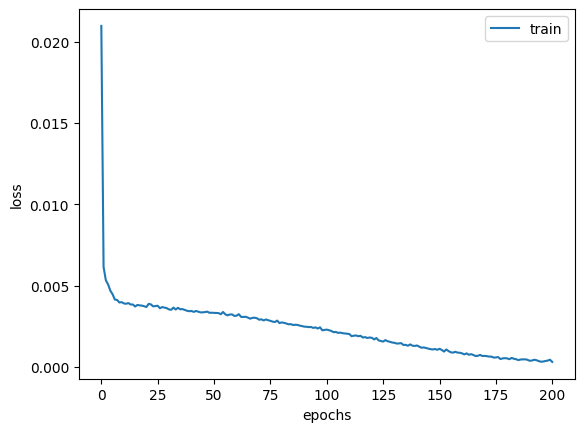

In [168]:
# 損失関数を描く

plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## 予測

In [169]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())
    

/var/folders/sz/wz3fwctj09n4x7hz4ry03tqh0000gn/T/ipykernel_98034/1814804422.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


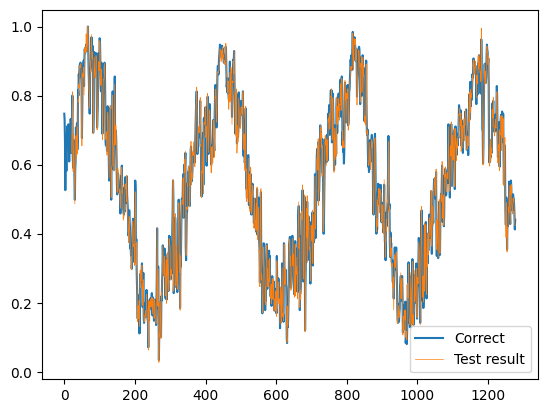

In [170]:
plt.plot(range(len(df_train)), df_train[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Test result',linewidth=0.5)
plt.legend()
plt.show()

↑

train データ で試しに モデルを実行した結果．ほぼ完全に一致している．


In [171]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_test_plot.append(y[0].item())
    

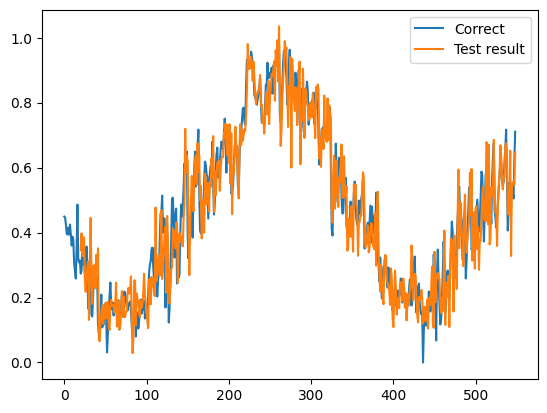

In [172]:
plt.plot(range(len(df_test)), df_test[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()

↑

test データを予測した結果 ( 正規化 )

In [173]:
predicted_test_plot_inversed = np.array(predicted_test_plot) * (max_avetem-min_avetem) + min_avetem
print(predicted_test_plot_inversed)



[10.9222971  12.63035574 10.35727085 10.39839463 12.22537206  8.18819546
  6.776611    8.28750641  9.25345415  9.78289978  3.96216651  8.8628015
 14.17309114  8.68522094  5.56086862  9.37193514  7.43646273  9.4896897
  7.12476739 10.47557653  8.84185703 11.1225588   2.02080515  1.81461384
  3.7588659   4.51650162  5.38440676  3.55919165  4.0028738   4.86663343
  5.67569421  4.11381056  5.59671753  5.7693758   3.27469391  2.95777868
  5.30552403  5.97247397  5.38378687  5.47025451  5.33348535  4.72767093
  5.73082214  7.68152249  3.28877772  3.5173981   5.95353832  2.99462934
  3.25676921  4.70216641  6.85289503  4.25828764  6.29605712  4.23369793
  4.28068788  4.75446609  4.86285114  6.72785969  7.16302176  6.58864827
  6.79194742  8.32118475  3.81676154  0.64080593  2.01137002  7.9344006
  7.86359967  3.43325795  6.60160394  6.04368896  5.87298238  4.63225366
  4.2311588   5.8719799   5.18277017  5.48790776  6.77056418  8.57917548
  6.4529615   5.7106162   4.94550162  3.80499528  3.13

In [174]:
df_test_inversed = np.array(df_test[:,2]) * (max_avetem-min_avetem) + min_avetem

df_test_inversed

array([14.3, 14.2, 13.5, 12.6, 12.5, 13.2, 12.5, 13.5, 12.5, 11.4, 12.3,
       12. ,  9.6,  8.9,  8.1, 11. , 15.5, 10.1,  9.7,  9.9,  8.6,  8.9,
       11.8,  9.5, 10.2,  8.6,  9.4, 11.3,  9.7,  5.1,  7.6,  9.5,  8.7,
        4.5,  4.3,  6.4,  8.2,  8.8,  8.3,  8. ,  8.3,  3.5,  2.7,  3.8,
        4.2,  6.5,  3.2,  3.4,  3.5,  5.5,  5.2,  4.1,  0.7,  2.6,  4.5,
        6.3,  7.7,  5.7,  5. ,  5.7,  4.4,  5.5,  5.4,  6. ,  4.4,  3.7,
        3.4,  3. ,  4.5,  5.1,  6.4,  5.2,  5.5,  6.8,  6.6,  5.9,  5.2,
        4.9,  5.6,  5.5,  5.8,  4.9,  3.5,  2.3,  4.5,  5.3,  6.2,  2.3,
        4.1,  4.7,  3.1,  3.9,  5.5,  6. ,  4.6,  5.7,  5. ,  5.9,  4.1,
        4.4,  4.4,  4.8,  6.5,  8.6,  9.5,  9.8, 11. , 11.2,  9.5,  8.1,
       11.2,  8.1,  8.3,  6.3,  7.9,  9. , 12. , 14.6, 14.7, 16.4, 12.7,
       14.1, 14.1,  5.2, 10.1,  9.9,  9.6,  3.7,  5.2,  8.2, 12.2, 16.1,
       16.2, 13.5, 10.2, 14.5, 15.1,  7.6,  8.5,  8.2,  8.5, 12.6, 15.5,
       14.3, 15.4, 17.2, 19.6, 18.9, 20. , 20.8, 12

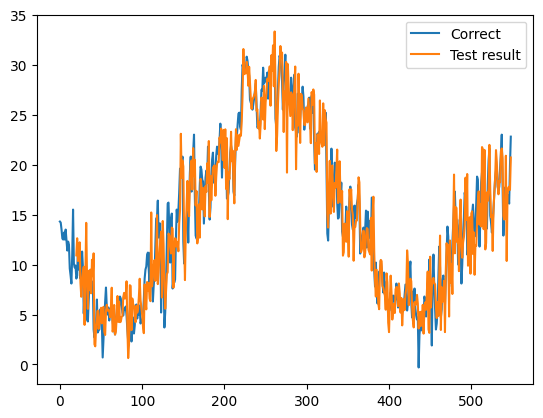

In [175]:
plt.plot(range(len(df_test_inversed)), df_test_inversed, label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot_inversed)), predicted_test_plot_inversed, label='Test result')
plt.legend()
plt.show()

↑

test データを予測した結果 (degree 単位)